# Model architecture

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, x_2, x_3 ... x_n )$ to a sequence of continuous representations $(z_1, z_2 .. z_n) $. Given z, the decoder then generates an output sequence $(y_1, y_2, ... y_n) $ of symbols one element at a time. At each step, the model is an autoregressive. Consuming the previously generated synbols as an additional input when generating the next.

In [103]:
#default_exp new_bert

In [126]:
#export
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")

In [127]:
#export
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [128]:
#export
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, src_mask,tgt, tgt_mask):
        " Take in and process masked src and target sequence"
        enc = self.encode(src,src_mask)
        return self.decode(enc, src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [154]:
#export
class Generator(nn.Module):
    "Define the standard linear + softmax generation step"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        # without using softmax
        return self.proj(x)

The transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both encoder and decoder, shown in the left and right halves of figure 1, respectively.

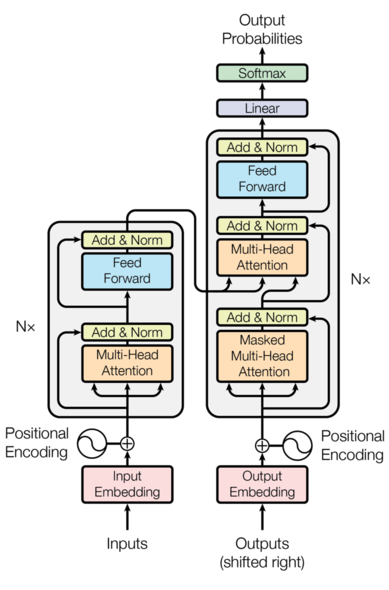

# Encoder and Decoder Stacks

## Encoder

Encoder is composed of a stack of N=6 identical layers.

In [155]:
#export
def clones(module, N):
    "Produce N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [156]:
#export
class Encoder(nn.Module):
    " Core ENcoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input and mask through each layer in turn"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
        

We employ a residual connection around each of the two sub-layers, followed by normalization

In [157]:
#export
class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * ( x - mean) / (std + self.eps) + self.b_2

In [158]:
#export
class SubLayerConnection(nn.Module):
    "A residual connection followed by a layernorm"
    def __init__(self, size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size"
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is multi-head self attention mechansim and the second is position wise fully connected network

In [159]:
#export
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout),2)
        self.size= size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x : self.attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

# Decoder

Decoder is composed of N=6 identical layers

In [160]:
#export
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
            
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-lyaer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we emnploy a residual connection around each of the sub-layers, followed by layer normalization

In [161]:
#export
class DecoderLayer(nn.Module):
    "Decoder is made up of self-attn, src-attn, feed forward"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout), 3)
        
    def forward(self ,x , memory,  src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x , lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    

In [162]:
#export
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

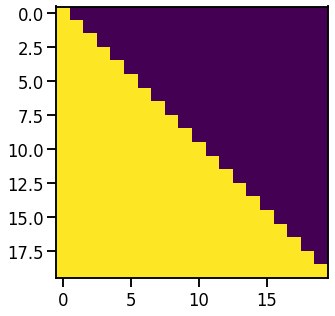

In [163]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

# Attention

In [164]:
#export
def attention(query, key, value, mask=None, dropout=None):
    " COmpute scaled dot product attention"
    
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim= -1)
    
    if dropout is not None:
        p_attn = dropout(p_attn)
        
    return torch.matmul(p_attn, value), p_attn

In [165]:
#export
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key ,value, mask=None):
        #if mask is not None:
        #    mask = mask.unsqueeze(1)
            
        nbatches = query.size(0)
        
        # Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        # Apply attention on all projected vectors in batch
        x, self.attn = attention(query, key , value, mask=mask, dropout=self.dropout)
        
        # Concat using a view and final layer
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        
        return self.linears[-1](x)        

# Applications of attention

The Transformer uses multi-head attention in three different ways: 1) In “encoder-decoder attention” layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as (cite).

2) The encoder contains self-attention layers. In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attend to all positions in the previous layer of the encoder.

3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot- product attention by masking out (setting to 
−
∞
) all values in the input of the softmax which correspond to illegal connections.



# Position wise feed forward networks

In [166]:
#export
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout= nn.Dropout(dropout)
        
    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

# Embeddings and softmax

In [167]:
#export
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super().__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

# Positional Encoding

In [168]:
#export
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

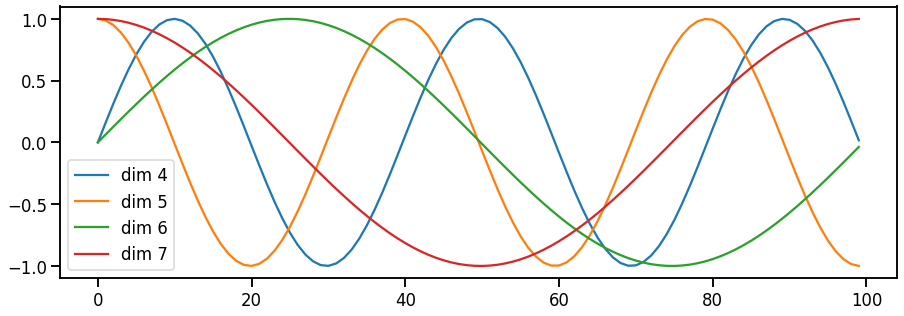

In [169]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

# Full Model

In [170]:
#export
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab)
    )
    
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return model

# Loss Function

In [184]:
#export
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm=1):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        return loss
    

class LabelSmoothingLoss(nn.Module):
    def __init__(self, label_smoothing = 0, num_classes=2, ignore_value = 1):
        super().__init__()
        self.confidence = 1 - label_smoothing
        self.smoothing = label_smoothing
        self.num_classes = num_classes
        self.ignore_value = ignore_value
        
    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing/ (self.num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)

        # calculate mask 
        mask = (target != self.ignore_value).unsqueeze(1)
    
        # mask for input
        pred = pred * mask
        
        # finding out the cross entropy SUM(Q(x) * log P(X))
        return torch.mean(torch.sum(-true_dist * F.log_softmax(pred,dim=-1) * mask, dim = -1))

        
class LabelSmoothingLoss2(torch.nn.Module):
    def __init__(self, label_smoothing: float = 0.1, reduction="mean", weight=None, ignore_value=1):
        super().__init__()
        self.epsilon = label_smoothing
        self.reduction = reduction
        self.weight = weight
        self.ignore_value = ignore_value

    def reduce_loss(self, loss):
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            return loss

    def linear_combination(self, x, y):
        return self.epsilon * x + (1 - self.epsilon) * y

    def forward(self, preds, target):
        if self.weight is not None:
            self.weight = self.weight.to(preds.device)

        if self.training:
            n = preds.size(-1)
            log_preds = F.log_softmax(preds, dim=-1)
            loss = self.reduce_loss(-log_preds.sum(dim=-1))
            nll = F.nll_loss(
                log_preds, target, reduction=self.reduction, weight=self.weight, ignore_index=self.ignore_value
            )
            
            
            return self.linear_combination(loss / n, nll)
        else:
            return torch.nn.functional.cross_entropy(preds, target, weight=self.weight)

# THE END